### Make necessary imports

## Exploration for Claims 1 & 2: ##
     Higher square footage & Having porch or deck increases home sale price

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.stats.api as sms

%matplotlib inline
plt.style.use('ggplot')

#from ltests import model

### Import our combined csv into a DataFrame

In [2]:
raw = pd.read_csv('../../data/master.csv', low_memory=False, dtype={'id': object})

In [3]:
#how many entries are there?
raw.shape[0]

62039

### We would like to select only those entries that have a sale price greater than 0

In [4]:
raw = raw[raw.SalePrice > 0]
raw.shape[0]

42214

### Now we select the sales with the proper PropertyType codes
The following are of interest to us:
 - 11: Household, single family units
 - 12: Multiple family residence (Residential, 2-4 units)
 - 13: Multiple family residence (Residential, 5+ units)
 - 14: Residential condominiums
  
*These codes can be found in the Lookup.zip file located at*

https://info.kingcounty.gov/assessor/DataDownload/default.aspx 

In [5]:
proptypes = [11]

df = raw[raw.PropertyType.isin(proptypes)]
df.shape[0]


19264

In [6]:
#add column to dataframe OutdoorSpace
df['OutdoorSpace']= df['SqFtOpenPorch']+df['SqFtEnclosedPorch']+df['SqFtDeck']

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
df.shape[0]

19264

In [8]:
#filling in NaN with zero
#assuming they are NaN because there is no porch or deck
df['OutdoorSpace'] = df['OutdoorSpace'].fillna(0)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
df.shape[0]

19264

### Generate our first simple model of Sale Price vs SqFtTotLiving & OutdoorSpace

In [10]:
fsm_df = df[["SalePrice", "SqFtTotLiving", "SqFtOpenPorch", "SqFtEnclosedPorch", "SqFtDeck"]].copy()
fsm_df.dropna(inplace=True)
formula = 'SalePrice ~ SqFtTotLiving+SqFtOpenPorch+SqFtEnclosedPorch+SqFtDeck'
fsm = ols(formula=formula, data=fsm_df).fit()

Let's see that big table

In [11]:
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     3062.
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:46:08   Log-Likelihood:            -2.7191e+05
No. Observations:               18807   AIC:                         5.438e+05
Df Residuals:                   18802   BIC:                         5.439e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -8797.1536   8238.142     -1.068      0.286   -2.49e+04    7350.347
SqFtTotLiving       353.7943      3.844     92.034      0.000     346.259     361.329
SqFtOpenPorch       265.1946     24.113     10.998      0.000     217.931     312.458
SqFtEnclosedPorch   169.9337     91.353      1.860      0.063      -9.126     348.994
SqFtDeck            188.9397     16.308     11.585      0.000     156.974     220.906
==============================================================================
Omnibus:                    24238.347   Durbin-Watson:                   1.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12882424.786
Skew:                           6.763   Prob(JB):                         0.00
Kurtosis:                     130.501   Cond. No.                     5.80e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
fsm_df.shape[0]

18807

## Check homoscedasticity

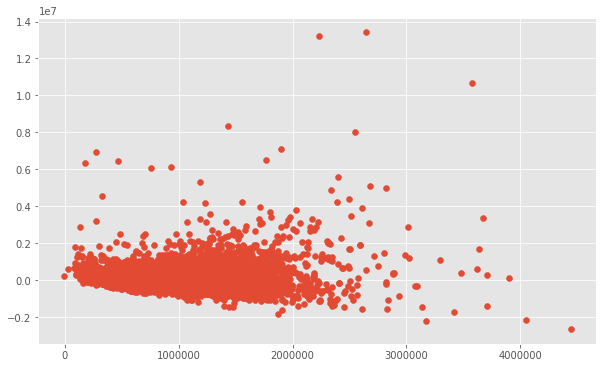

In [13]:
fsm_resids = fsm.resid
y_hat = fsm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, fsm_resids);

## check normality with Q-Q plot

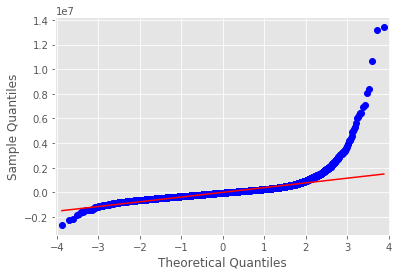

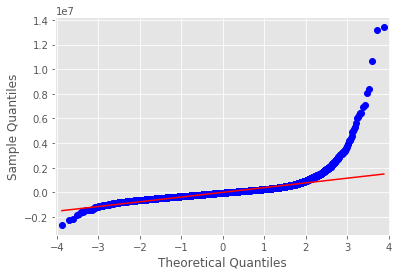

In [14]:
sm.qqplot(fsm_resids, line='r')

## check normality with Jarque Bera test

In [15]:
name = ['JB', 'Prob', 'Skew', 'Kurtosis']
test = sms.jarque_bera(fsm.resid)
list(zip(name, test))

[('JB', 12882424.785946423),
 ('Prob', 0.0),
 ('Skew', 6.763121033290944),
 ('Kurtosis', 130.50124837733352)]

### Let's try do drop some outliers 

let's remove elements with a z-score outsize of [-3,3] in either the sale price or the square foot columns

In [16]:
from scipy import stats
ssm_df = fsm_df[(np.abs(stats.zscore(fsm_df)) < 3).all(axis=1)]

In [17]:
formula = 'SalePrice ~ SqFtTotLiving+SqFtOpenPorch+SqFtEnclosedPorch+SqFtDeck'
ssm = ols(formula=formula, data=ssm_df).fit()

In [18]:
ssm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     2610.
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:46:21   Log-Likelihood:            -2.4675e+05
No. Observations:               17606   AIC:                         4.935e+05
Df Residuals:                   17601   BIC:                         4.936e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.599e+05   6086.829     26.263      0.000    1.48e+05    1.72e+05
SqFtTotLiving       260.5591      2.991     87.123      0.000     254.697     266.421
SqFtOpenPorch       201.7634     26.216      7.696      0.000     150.378     253.149
SqFtEnclosedPorch  1267.9252    192.852      6.575      0.000     889.917    1645.933
SqFtDeck            165.6562     13.566     12.211      0.000     139.065     192.247
==============================================================================
Omnibus:                     3678.283   Durbin-Watson:                   0.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10032.333
Skew:                           1.118   Prob(JB):                         0.00
Kurtosis:                       5.946   Cond. No.                     6.05e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Check homoscedasticity again

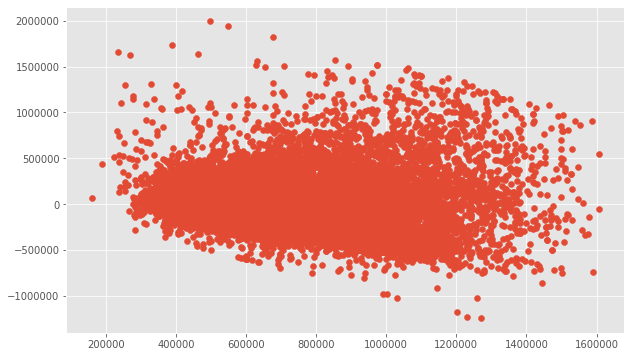

In [19]:
ssm_resids = ssm.resid
y_hat = ssm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, ssm_resids);

## check normality with Q-Q plot again

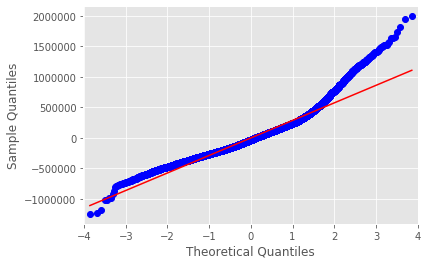

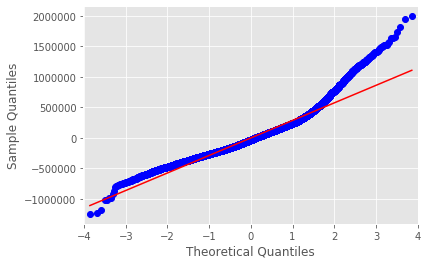

In [20]:
sm.qqplot(ssm_resids, line='r')

## check normality with Jarque Bera test again

In [21]:
name = ['JB', 'Prob', 'Skew', 'Kurtosis']
test = sms.jarque_bera(ssm.resid)
list(zip(name, test))

[('JB', 10032.333446381088),
 ('Prob', 0.0),
 ('Skew', 1.1176259719358086),
 ('Kurtosis', 5.9460891441096795)]